## Quantum Scrambling

This is an implementation of the quantum scrambling and teleportation algorithm from [this paper](https://arxiv.org/pdf/1806.02807.pdf).

The scrambling circuit is initiallized with a source state $\vert \psi \rangle$, five ancillary qubit systems and a target state that are all initialized in $\vert 0 \rangle$.

The circuit is split in 2 times 3 qubits plus the line that will contain the target state $\vert \phi \rangle$ after a successful teleportation. We numerate them from top to bottom starting with 0.

We build EPR pairs with the qubits (1,4), (2,3) and (5,6). This is depicted with the element:

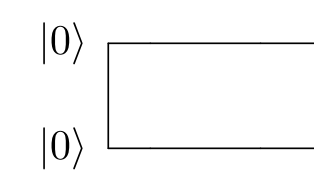

The whole circuit can be either built like this:

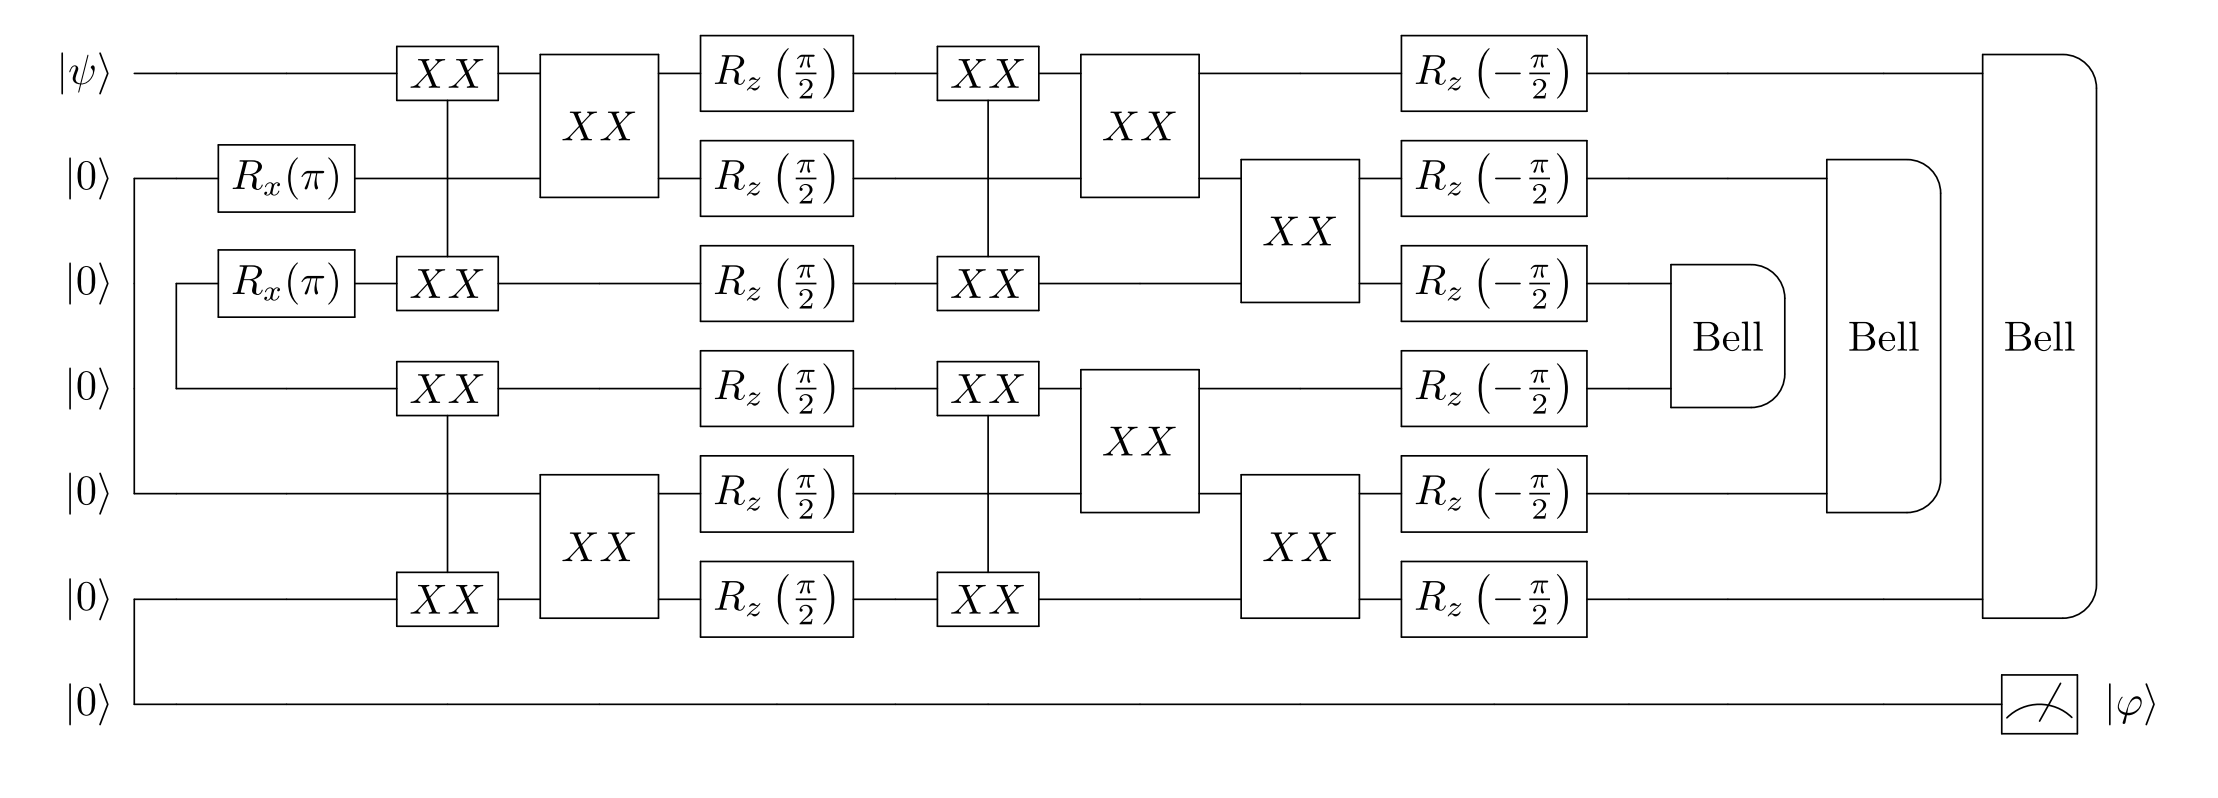

Or we can also replace the circuit for the qubits 0 to 2 and 3 to 5 with this simpler circuit:

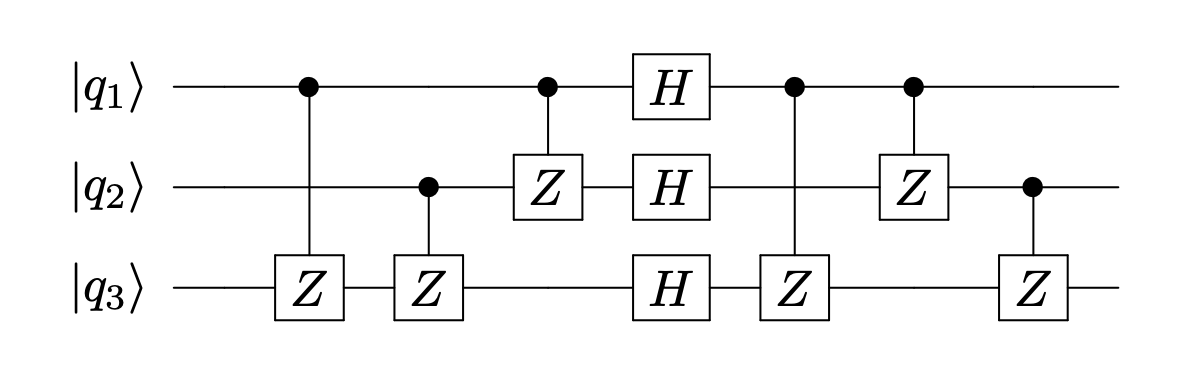

We used the second implementation for Rigetti because most of the gates that are used are native on Rigetti. Therefore we do not have to further compile the circuit. 

In [3]:
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.quil import DefGate
import numpy as np
from forest_tools import plot_circuit
qc = get_qc('7q-qvm')
sqrt2 = 1/np.sqrt(2) 
π = np.pi

def add_EPR_gate(program, qubit_number1, qubit_number2):
    program += H(qubit_number1)
    program += CNOT(qubit_number1, qubit_number2)
    return

def add_XX_gate(program, qubit_number1, qubit_number2):
    XX_gate = XX.get_constructor()
    program += XX
    program += XX_gate(qubit_number1,qubit_number2)
    return 

def add_Bell_measure(program, qubit_number1, qubit_number2):
    program += CNOT(qubit_number1, qubit_number2)
    program += H(qubit_number1)    
    
xx_array = sqrt2*np.array([[1,0,0,sqrt2*(-1-1j)],[0,1,-1j,0],[0,-1j,1,0],[sqrt2*(1-1j),0,0,1]])
XX = DefGate("XX_Gate", xx_array)

In [4]:
def add_scrambling_CZ(q0, q1, q2):
    program = Program()
    program += CZ(q0, q2)
    program += CZ(q1, q2)
    program += CZ(q0, q1)
    program += H(q0)
    program += H(q1)
    program += H(q2)
    program += CZ(q0, q2)
    program += CZ(q0, q1)
    program += CZ(q1, q2)
    return program

In [36]:
n_measurements = 1000
program = Program()
#program += X(0)
#program += H(0)
add_EPR_gate(program, 1, 4)
add_EPR_gate(program, 2, 3)
add_EPR_gate(program, 5, 6)
program += add_scrambling_CZ(0, 1, 2)
program += add_scrambling_CZ(3, 4, 5)
add_Bell_measure(program, 2, 3) 
add_Bell_measure(program, 1, 4)
add_Bell_measure(program, 0, 5)
result = qc.run_and_measure(program, n_measurements)

## Successful Bell measurement

We are only interested in the target state if the Bell measurement was sucessful. This means if we measure [0,0] at the Bell measurement we take the statistics of the target state measurements.

In [37]:
target_bell_pair = (2, 3)
ancilla_output = np.array([result[6][i] for i in range(n_measurements) if result[target_bell_pair[0]][i] == 0 and result[target_bell_pair[1]][i] == 0])
print("target state was measured in |0> state {} times and in |1> state {} times".format(np.sum(ancilla_output==0), np.sum(ancilla_output==1)))

target state was measured in |0> state 246 times and in |1> state 0 times
